In [46]:
import pandas as pd
import numpy as np
import locale

locale.setlocale(locale.LC_TIME,'')
pd.options.plotting.backend = "plotly"

In [105]:
ts = pd.read_pickle("orders.pkl")
ts[ts.n_orders==0] = 1
ts.plot(title=f'Nb. de commandes par jour de {ts.index[0].strftime("%d-%m-%Y")} au {ts.index[-1].strftime("%d-%m-%Y")}')

La série décrit le nombre de commandes livrées par jour du 02 janvier 2020 au 15 octobre 2021 soit jours. On observe une forte saisonalité sur les jours de la semaine. Une modélisation par un modèle SARIMA peut être envisagé.

In [48]:
weekdays = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
ts.groupby(ts.index.strftime("%A")).mean().reindex(weekdays).plot(title="Nb. moyen de commandes par jour")

Cependant, il est clair que la série n'est pas stationnaire car :
- il semble y avoir une tendance légèrement à la hausse.
- la série ne semble pas avoir une variance constante au cours du temps.

Il faut alors dans un premier temps corrigé ces problèmes d'hétéroscédasticité. Plusieurs transformation existe pour y parvenir :
- passage au log
- Box-Cox
- autres ?

In [106]:
ts["log_n_orders"] = np.log(ts.n_orders)
ts.log_n_orders.plot()

On observe une forte réduction de la variance.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p and q for the ARMA model, the AR and MA parameters can then be estimated.

Regarding other possible uses of Box-Cox in the case of a series of iid random variables that do not appear to be normally distributed there may be a particular value of lambda that makes the data look approximately normal.

Presumably this could be applied in regression or time series to the error term.

maxlog=0.3294674508081416


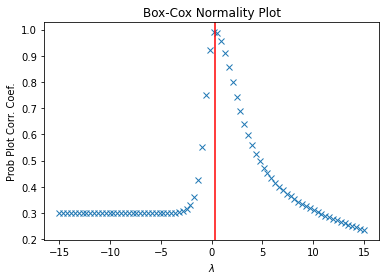

In [107]:
from scipy.stats import boxcox, boxcox_normplot
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
prob = boxcox_normplot(ts.n_orders, -15, 15, plot=ax)
_, maxlog = boxcox(ts.n_orders)
ax.axvline(maxlog, color='r')
print(f"{maxlog=}")

In [108]:
ts["boxcox"] = boxcox(ts.n_orders, lmbda=maxlog)
ts.boxcox.plot()

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import 
from statsmodels.tsa.stattools import adfuller, kpss

In [112]:
decomp = seasonal_decompose(ts.n_orders, model='additive')
decomp.resid.plot()

In [125]:
# Tests de stationatité

y = decomp.resid.dropna()

# ADF Test
result = adfuller(y, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(y, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -11.092972805581004
p-value: 4.038743158989153e-20
Critial Values:
   1%, -3.440822526288827
Critial Values:
   5%, -2.8661606613087542
Critial Values:
   10%, -2.5692307337540603

KPSS Statistic: 0.040029
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/amait/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/home/amait/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [126]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(decomp.resid.dropna().values, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,930.167114,2.043777e-193
